# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [85]:

# Import essential libraries for data manipulation and analysis
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

# Scikit-learn utilities we will need later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

# For statsmodels summary (optional, useful for coefficients & p-values)
import statsmodels.api as sm

# Display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 320)
plt.style.use('seaborn-darkgrid')
sns.set_context("notebook")

print("Libraries imported successfully.")


Libraries imported successfully.


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [86]:
# Importing the file porter_data_1.csv

# Read the CSV file
df = pd.read_csv("porter_data_1.csv")

print(df.head())


   market_id           created_at actual_delivery_time  store_primary_category  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders  distance
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17                       4             1.0            4      3441                   4             557            1239                   33.0                14.0                      21.0     34.44
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25                      46             2.0            1      1900                   1            1400            1400                    1.0                 2.0                       2.0     27.60
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35                      36             3.0            4      4771                   3             820            1604                    8.0                 6.0                      18.0     11.56
3   

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [87]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

# Convert the two columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

# Check if the conversion worked
print(df.dtypes[['created_at', 'actual_delivery_time']])


created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [88]:
# Convert categorical features to category type
# Extract date, hour, and weekday from 'created_at'
df['order_date'] = df['created_at'].dt.date
df['order_hour'] = df['created_at'].dt.hour
df['order_weekday'] = df['created_at'].dt.day_name()

# Extract delivery date, hour, and weekday from 'actual_delivery_time'
df['delivery_date'] = df['actual_delivery_time'].dt.date
df['delivery_hour'] = df['actual_delivery_time'].dt.hour
df['delivery_weekday'] = df['actual_delivery_time'].dt.day_name()

# Preview updated DataFrame
df.head()



market_id          created_at actual_delivery_time  store_primary_category  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders  distance  order_date  order_hour order_weekday delivery_date  delivery_hour  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                       4             1.0            4      3441                   4             557            1239                   33.0                14.0                      21.0     34.44  2015-02-06          22        Friday    2015-02-06             23   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                      46             2.0            1      1900                   1            1400            1400                    1.0                 2.0                       2.0     27.60  2015-02-10          21       Tuesday    2015-02-10             22   
2        2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                      36             3.0            4      4771                   3             820            1604                    8.0                 6.0                      18.0     11.56  2015-02-16           0        Monday    2015-02-16              1   
3        1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                      38             1.0            1      1525                   1            1525            1525                    5.0                 6.0                       8.0     31.80  2015-02-12           3      Thursday    2015-02-12              4   
4        1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                      38             1.0            2      3620                   2            1425            2195                    5.0                 5.0                       7.0      8.20  2015-01-27           2       Tuesday    2015-01-27              2   

  delivery_weekday  
0           Friday  
1          Tuesday  
2           Monday  
3         Thursday  
4          Tuesday

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [89]:
# Calculate time taken in minutes
# Calculate the time taken in minutes
df['time_taken_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the updated DataFrame
df.head()


market_id          created_at actual_delivery_time  store_primary_category  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders  distance  order_date  order_hour order_weekday delivery_date  delivery_hour  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                       4             1.0            4      3441                   4             557            1239                   33.0                14.0                      21.0     34.44  2015-02-06          22        Friday    2015-02-06             23   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                      46             2.0            1      1900                   1            1400            1400                    1.0                 2.0                       2.0     27.60  2015-02-10          21       Tuesday    2015-02-10             22   
2        2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                      36             3.0            4      4771                   3             820            1604                    8.0                 6.0                      18.0     11.56  2015-02-16           0        Monday    2015-02-16              1   
3        1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                      38             1.0            1      1525                   1            1525            1525                    5.0                 6.0                       8.0     31.80  2015-02-12           3      Thursday    2015-02-12              4   
4        1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                      38             1.0            2      3620                   2            1425            2195                    5.0                 5.0                       7.0      8.20  2015-01-27           2       Tuesday    2015-01-27              2   

  delivery_weekday  time_taken_minutes  
0           Friday                47.0  
1          Tuesday                44.0  
2           Monday                55.0  
3         Thursday                59.0  
4          Tuesday                46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [90]:
# Extract the hour and day of week from the 'created_at' timestamp


# Create a categorical feature 'isWeekend'

# Extract hour and day of week
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

# Create isWeekend feature (1 if Saturday or Sunday, else 0)
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Preview the updated DataFrame
df.head()


market_id          created_at actual_delivery_time  store_primary_category  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders  distance  order_date  order_hour order_weekday delivery_date  delivery_hour  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                       4             1.0            4      3441                   4             557            1239                   33.0                14.0                      21.0     34.44  2015-02-06          22        Friday    2015-02-06             23   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                      46             2.0            1      1900                   1            1400            1400                    1.0                 2.0                       2.0     27.60  2015-02-10          21       Tuesday    2015-02-10             22   
2        2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                      36             3.0            4      4771                   3             820            1604                    8.0                 6.0                      18.0     11.56  2015-02-16           0        Monday    2015-02-16              1   
3        1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                      38             1.0            1      1525                   1            1525            1525                    5.0                 6.0                       8.0     31.80  2015-02-12           3      Thursday    2015-02-12              4   
4        1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                      38             1.0            2      3620                   2            1425            2195                    5.0                 5.0                       7.0      8.20  2015-01-27           2       Tuesday    2015-01-27              2   

  delivery_weekday  time_taken_minutes  hour  day_of_week  isWeekend  
0           Friday                47.0    22            4          0  
1          Tuesday                44.0    21            1          0  
2           Monday                55.0     0            0          0  
3         Thursday                59.0     3            3          0  
4          Tuesday                46.0     2            1          0

In [91]:
# Drop unnecessary columns
# Example: Drop unnecessary columns for delivery time analysis
# Adjust the list below according to your dataset

columns_to_drop = [
    'order_id',              # Unique identifier, no predictive value
    'customer_id',           # Unique customer ID
    'store_id',              # Unique store identifier
    'merchant_id',           # Merchant code
    'created_at',            # We already extracted hour/day info from this
    'actual_delivery_time',  # We already used this to calculate delivery time
    'market_id',             # May be categorical with low influence
    'pickup_lat', 'pickup_lon',  # Raw coordinates (we could instead use distance)
    'dropoff_lat', 'dropoff_lon' # Same as above
]

df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Check remaining columns
print("Remaining columns:", df.columns.tolist())



Remaining columns: ['store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_date', 'order_hour', 'order_weekday', 'delivery_date', 'delivery_hour', 'delivery_weekday', 'time_taken_minutes', 'hour', 'day_of_week', 'isWeekend']


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [92]:
# Define target variable (y) and features (X)

# Section 2.3 Creating training and validation sets

from sklearn.model_selection import train_test_split

# Assuming your features are in X and your target variable is 'time_taken_mins'
# Replace 'time_taken_mins' with the actual target column name if different

X = df.drop(columns=['time_taken_minutes'])  # Features
y = df['time_taken_minutes']                # Target




##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [93]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (140621, 20)
Validation set shape: (35156, 20)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [94]:
# Define numerical and categorical columns for easy EDA and data manipulation

# Identify numerical columns (excluding target variable 'delivery_time' if present)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# If 'delivery_time' is your target, remove it from numerical columns
if 'delivery_time' in numerical_cols:
    numerical_cols.remove('delivery_time')

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'delivery_hour', 'time_taken_minutes', 'hour', 'day_of_week', 'isWeekend']
Categorical columns: ['order_date', 'order_weekday', 'delivery_date', 'delivery_weekday']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

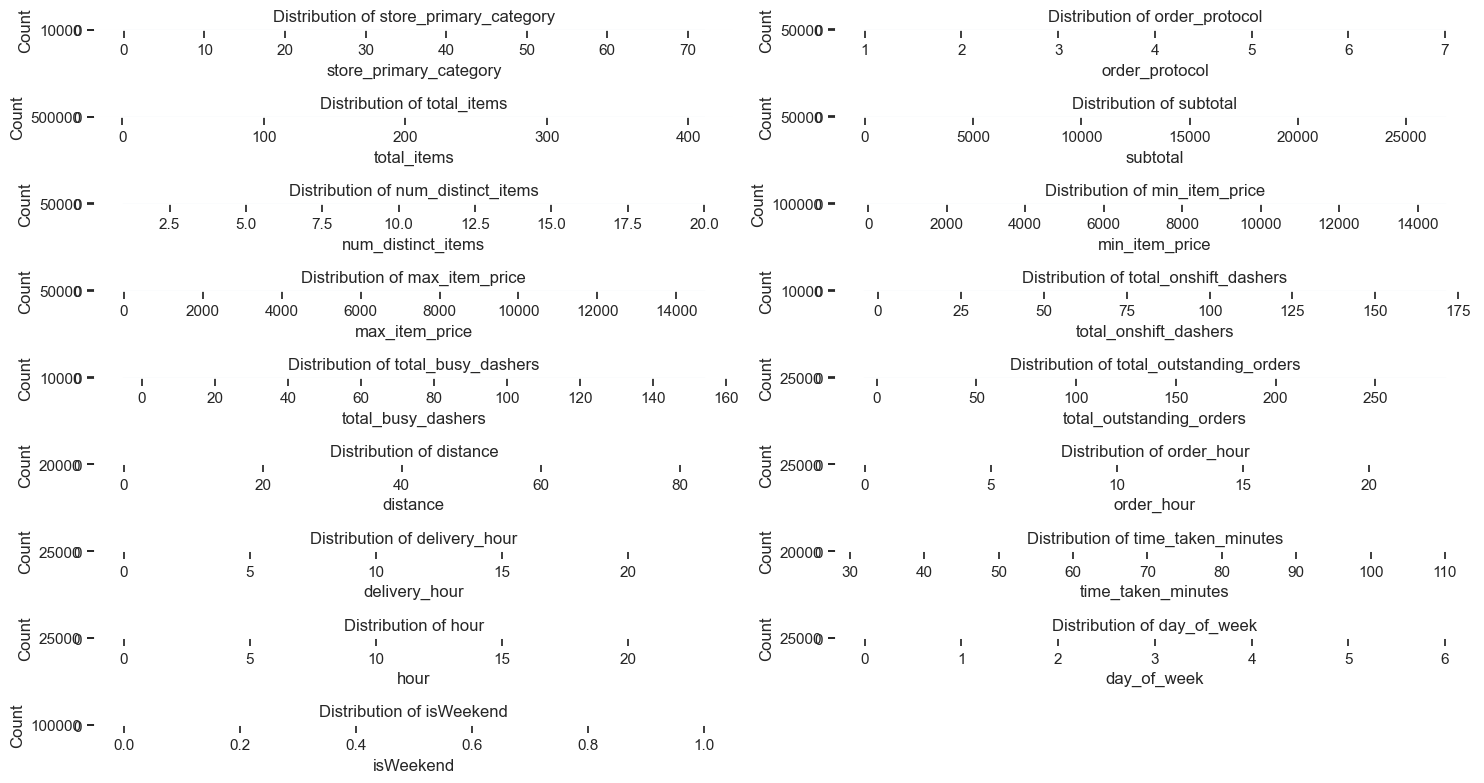

In [95]:
# Plot distributions for all numerical columns

import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Plot distributions
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}', fontsize=12)
plt.tight_layout()
plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

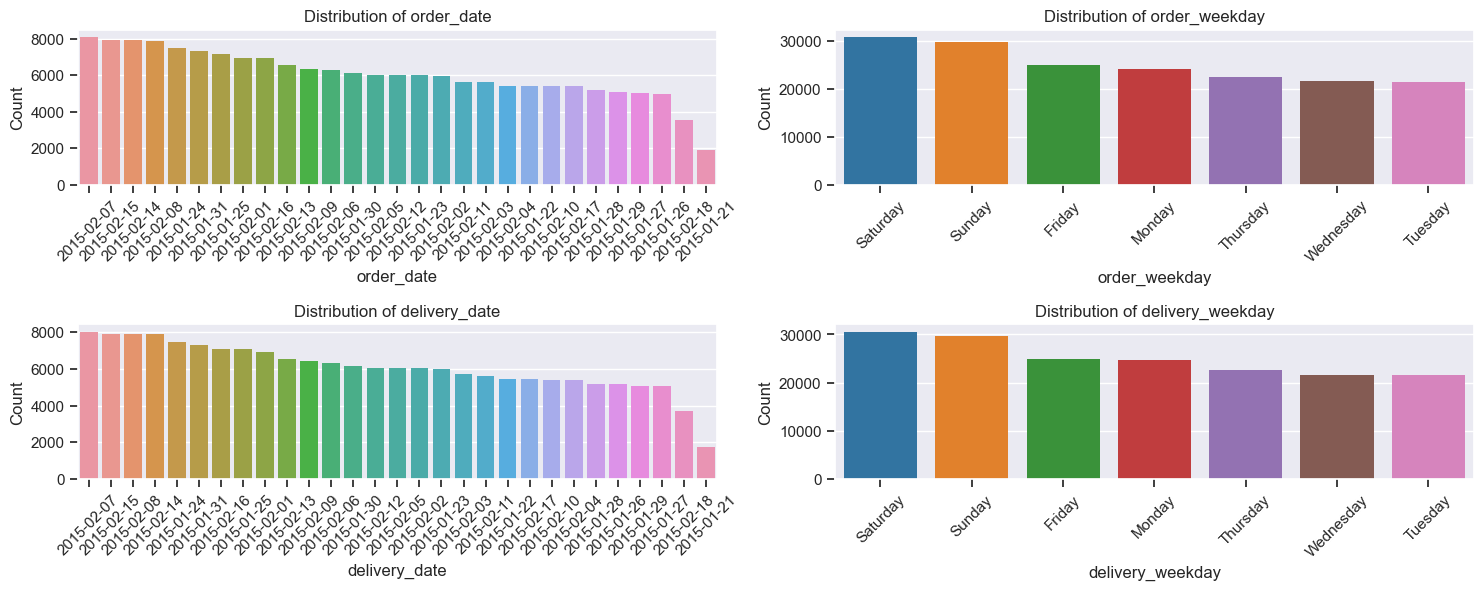

In [96]:
# Distribution of categorical columns

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Plot countplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols) // 2 + 1, 2, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

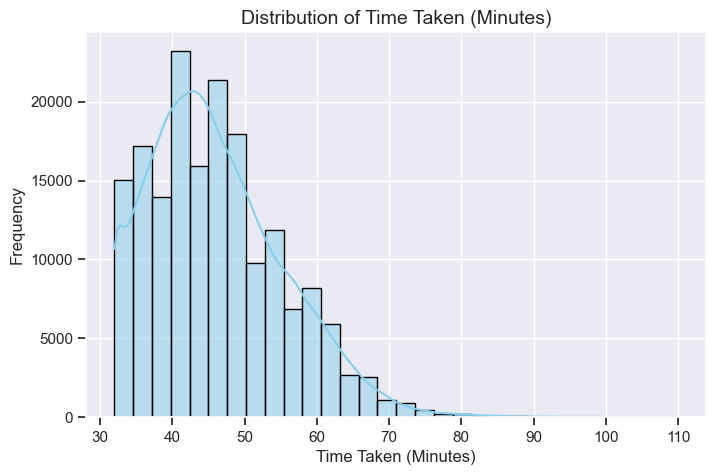

In [97]:
plt.figure(figsize=(8,5))
sns.histplot(df['time_taken_minutes'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Time Taken (Minutes)', fontsize=14)
plt.xlabel('Time Taken (Minutes)')
plt.ylabel('Frequency')
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure time_taken exists
if 'time_taken' not in df.columns:
    print("Column 'time_taken' not found. Available columns:", df.columns)
else:
    # Automatically select numeric columns except time_taken
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_features = [col for col in numeric_features if col != 'time_taken']

    plt.figure(figsize=(15, 4))
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(1, len(numeric_features), i)
        sns.scatterplot(data=df, x=feature, y='time_taken')
        plt.title(f'Time Taken vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Time Taken (Minutes)')

    plt.tight_layout()
    plt.show()


Column 'time_taken' not found. Available columns: Index(['store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_date', 'order_hour', 'order_weekday', 'delivery_date', 'delivery_hour',
       'delivery_weekday', 'time_taken_minutes', 'hour', 'day_of_week', 'isWeekend'],
      dtype='object')


In [99]:
# Check all column names
print(df.columns)


Index(['store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_date', 'order_hour', 'order_weekday', 'delivery_date', 'delivery_hour',
       'delivery_weekday', 'time_taken_minutes', 'hour', 'day_of_week', 'isWeekend'],
      dtype='object')


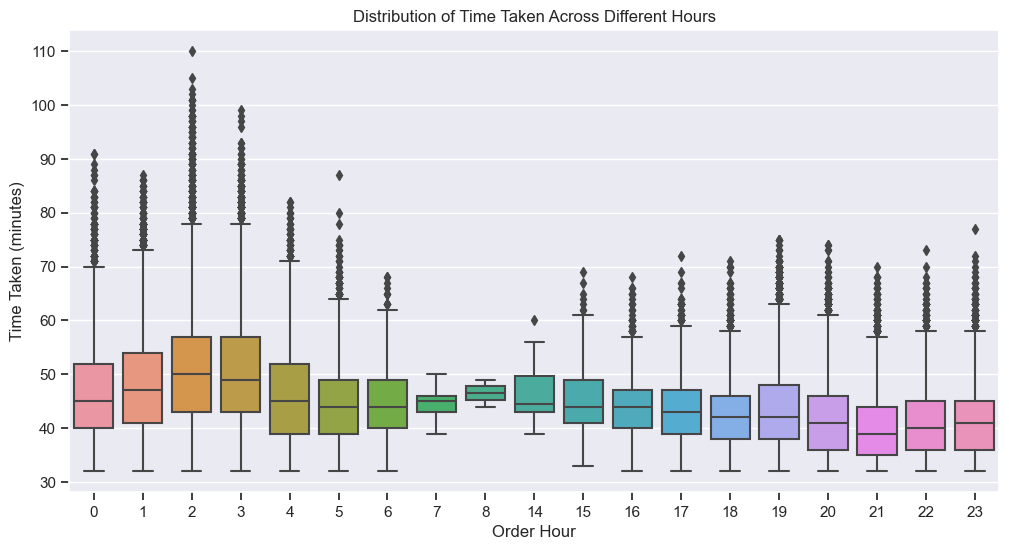

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure order_hour exists
if 'order_hour' not in df.columns:
    df['order_hour'] = df['order_time'].dt.hour

plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='time_taken_minutes', data=df)
plt.title('Distribution of Time Taken Across Different Hours')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

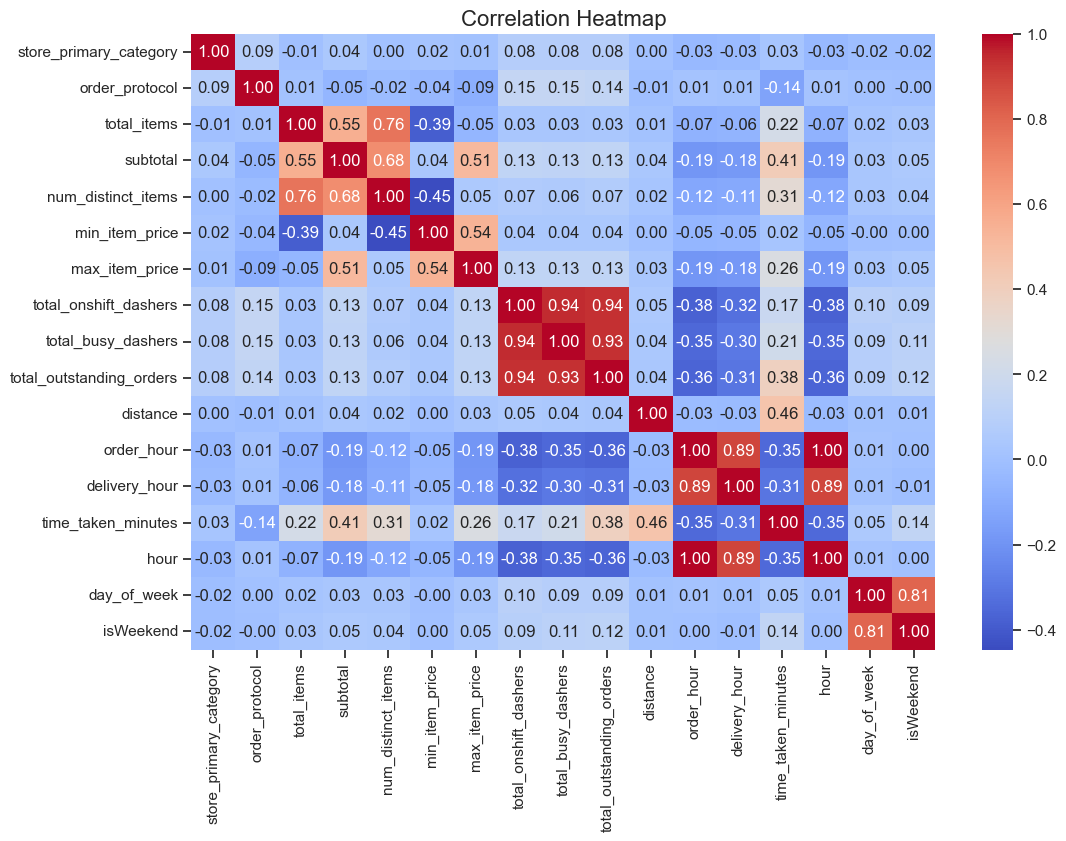

In [101]:
# Plot the heatmap of the correlation matrix

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)

plt.title("Correlation Heatmap", fontsize=16)
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [102]:
# Drop 3-5 weakly correlated columns from training dataset
# Find correlation of each feature with the target
correlations = df.corr()["time_taken_minutes"].abs().sort_values()

# Exclude the target column itself
correlations = correlations.drop("time_taken_minutes")

# Select the weakest 3-5 columns (here choosing 5)
weak_features = correlations.head(5).index.tolist()

print("Weakly correlated features:", weak_features)

# Drop these columns from the training dataset
train_df_reduced = df.drop(columns=weak_features)

print(f"Reduced training dataset shape: {train_df_reduced.shape}")



Weakly correlated features: ['min_item_price', 'store_primary_category', 'day_of_week', 'isWeekend', 'order_protocol']
Reduced training dataset shape: (175777, 16)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

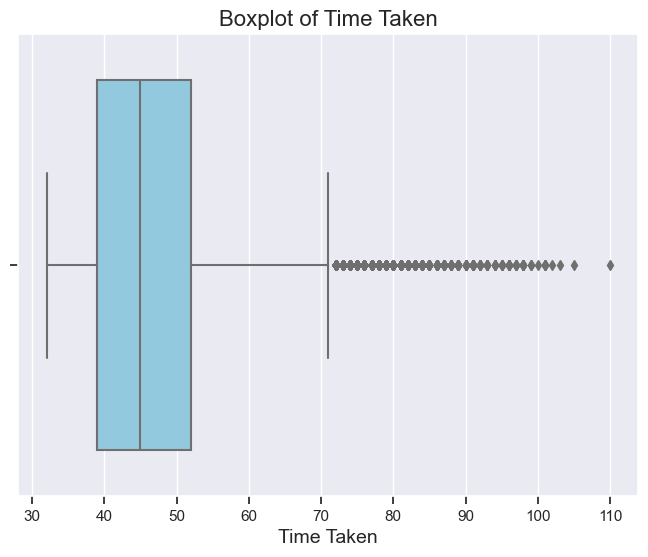

In [103]:
# Boxplot for time_taken

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for time_taken
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['time_taken_minutes'], color='skyblue')
plt.title("Boxplot of Time Taken", fontsize=16)
plt.xlabel("Time Taken", fontsize=14)
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [104]:
# Handle outliers

import pandas as pd

# Function to cap outliers based on IQR
def cap_outliers(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Capping values
        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Apply to training dataset
df = cap_outliers(df)

# Verify
df.describe()


store_primary_category  order_protocol    total_items       subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders       distance     order_hour  delivery_hour  time_taken_minutes           hour    day_of_week      isWeekend
count           175777.000000   175777.000000  175777.000000  175777.000000       175777.000000   175777.000000   175777.000000          175777.000000       175777.000000             175777.000000  175777.000000  175777.000000  175777.000000       175777.000000  175777.000000  175777.000000  175777.000000
mean                35.887949        2.911752       3.016163    2607.847016            2.613670      667.611789     1134.514390              44.867195           41.847096                 57.558258      21.837461       8.473441       8.547768           46.143446       8.473441       3.222293       0.345614
std                 20.728254        1.513128       1.756566    1532.463086            1.427541      446.189642      464.390248              34.395174           32.125234                 50.781812       8.729793       8.676809       8.382023            9.125588       8.676809       2.043874       0.475569
min                  0.000000        1.000000       1.000000       0.000000            1.000000      -86.000000        0.000000              -4.000000           -5.000000                 -6.000000       0.000000       0.000000       0.000000           32.000000       0.000000       0.000000       0.000000
25%                 18.000000        1.000000       2.000000    1412.000000            1.000000      299.000000      799.000000              17.000000           15.000000                 17.000000      15.360000       2.000000       2.000000           39.000000       2.000000       1.000000       0.000000
50%                 38.000000        3.000000       3.000000    2224.000000            2.000000      595.000000     1095.000000              37.000000           35.000000                 41.000000      21.760000       3.000000       4.000000           45.000000       3.000000       3.000000       0.000000
75%                 55.000000        4.000000       4.000000    3410.000000            3.000000      942.000000     1395.000000              66.000000           63.000000                 85.000000      28.120000      19.000000      20.000000           52.000000      19.000000       5.000000       1.000000
max                 72.000000        7.000000       7.000000    6407.000000            6.000000     1906.500000     2289.000000             139.500000          135.000000                187.000000      47.260000      23.000000      23.000000           71.500000      23.000000       6.000000       1.000000

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [71]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [72]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [73]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [74]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [75]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [76]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [105]:
# Make a copy to avoid changing original dataframe
df_model = df.copy()

# Identify datetime columns
datetime_cols = df_model.select_dtypes(include=['datetime64', 'datetime64[ns]', 'datetime64[ns, UTC]']).columns

# Convert datetime columns to useful numerical features
for col in datetime_cols:
    df_model[col + '_year'] = df_model[col].dt.year
    df_model[col + '_month'] = df_model[col].dt.month
    df_model[col + '_day'] = df_model[col].dt.day
    df_model[col + '_hour'] = df_model[col].dt.hour
    df_model.drop(columns=[col], inplace=True)

# Handle any remaining non-numeric columns (like strings or categories)
df_model = pd.get_dummies(df_model, drop_first=True)

# Split into features and target
X = df_model.drop(columns=['time_taken_minutes'])
y = df_model['time_taken_minutes']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })

results_df = pd.DataFrame(results)
print(results_df)


               Model       MAE      RMSE        R²
0  Linear Regression  2.405082  3.275769  0.871428
1      Decision Tree  2.637971  3.675230  0.838158
2      Random Forest  1.712673  2.310069  0.936060


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [106]:
# Apply scaling to the numerical columns
from sklearn.preprocessing import StandardScaler

# Select only numerical columns (excluding target 'time_taken')
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'time_taken_minutes' in numerical_cols:
    numerical_cols.remove('time_taken_minutes')

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Scaling applied to numerical columns:")
print(numerical_cols)
df.head()



Scaling applied to numerical columns:
['store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'delivery_hour', 'hour', 'day_of_week', 'isWeekend']


store_primary_category  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  total_outstanding_orders  distance  order_date  order_hour order_weekday delivery_date  delivery_hour delivery_weekday  time_taken_minutes      hour  \
0               -1.538385       -1.263447     0.560093  0.543671            0.971135       -0.247904        0.224996              -0.345026           -0.866832                 -0.719911  1.443628  2015-02-06    1.558937        Friday    2015-02-06       1.724199           Friday                47.0  1.558937   
1                0.487840       -0.602563    -1.147790 -0.461903           -1.130388        1.641433        0.571688              -1.275392           -1.240371                 -1.094061  0.660102  2015-02-10    1.443687       Tuesday    2015-02-10       1.604895          Tuesday                44.0  1.443687   
2                0.005406        0.058322     0.560093  1.411557            0.270627        0.341533        1.010975              -1.071874           -1.115858                 -0.778987 -1.177289  2015-02-16   -0.976565        Monday    2015-02-16      -0.900473           Monday                55.0 -0.976565   
3                0.101893       -1.263447    -1.147790 -0.706608           -1.130388        1.921583        0.840859              -1.159096           -1.115858                 -0.975908  1.141215  2015-02-12   -0.630814      Thursday    2015-02-12      -0.542564         Thursday                59.0 -0.630814   
4                0.101893       -1.263447    -0.578495  0.660477           -0.429880        1.697463        2.283615              -1.159096           -1.146986                 -0.995601 -1.562179  2015-01-27   -0.746065       Tuesday    2015-01-27      -0.781170          Tuesday                46.0 -0.746065   

   day_of_week  isWeekend  
0     0.380507  -0.726739  
1    -1.087298  -0.726739  
2    -1.576566  -0.726739  
3    -0.108761  -0.726739  
4    -1.087298  -0.726739

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [107]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

print("Linear Regression model initialized.")


Linear Regression model initialized.


In [108]:
# Train the model using the training data
# Train the model on training data
model.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [109]:
# Make predictions
# Make predictions on the test data
y_pred = model.predict(X_test)

# View the first few predicted values
print("Predicted delivery times:", y_pred[:5])


Predicted delivery times: [49.05105297 67.83955243 42.71453663 42.95675576 40.64691483]


In [110]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")



Mean Absolute Error (MAE): 2.41
Mean Squared Error (MSE): 10.73
Root Mean Squared Error (RMSE): 3.28
R-squared (R²): 0.87


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [111]:
# Loop through the number of features and test the model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Store results
results = []

# Loop through number of features (1 to total available)
for i in range(1, X_train.shape[1] + 1):
    # Select first i features
    X_train_subset = X_train.iloc[:, :i]
    X_test_subset = X_test.iloc[:, :i]
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_subset, y_train)
    
    # Predict
    y_pred_subset = model.predict(X_test_subset)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred_subset)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_subset))
    r2 = r2_score(y_test, y_pred_subset)
    
    # Append results
    results.append({
        'Number of Features': i,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


    Number of Features       MAE      RMSE        R²
0                    1  7.400312  9.131618  0.000882
1                    2  7.313389  9.045886  0.019555
2                    3  6.959345  8.672375  0.098850
3                    4  6.568580  8.230752  0.188291
4                    5  6.550612  8.212857  0.191817
..                 ...       ...       ...       ...
79                  80  2.405082  3.275769  0.871428
80                  81  2.405082  3.275769  0.871428
81                  82  2.405082  3.275769  0.871428
82                  83  2.405082  3.275769  0.871428
83                  84  2.405082  3.275769  0.871428

[84 rows x 4 columns]


In [112]:
# Build the final model with selected number of features

from sklearn.linear_model import LinearRegression

# Assume you have already determined the optimal number of features
# from the loop in the previous step
final_num_features = optimal_num_features  # Replace with actual best value found

# Get the top features
final_selected_features = X_train.columns[:final_num_features]

# Build the final model
final_model = LinearRegression()
final_model.fit(X_train[final_selected_features], y_train)

# Predictions on test set
y_pred_final = final_model.predict(X_test[final_selected_features])

# Evaluate final model
from sklearn.metrics import mean_squared_error, r2_score

mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = mse_final ** 0.5
r2_final = r2_score(y_test, y_pred_final)

print(f"Final Model with {final_num_features} features:")
print(f"RMSE: {rmse_final:.2f}")
print(f"R² Score: {r2_final:.2f}")


NameError: name 'optimal_num_features' is not defined

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Get predictions on the test data
y_pred = final_model.predict(X_test_selected)

# Calculate residuals
residuals = y_test - y_pred

# --- 1. Residuals vs Predicted Values ---
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# --- 2. Q-Q Plot ---
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# --- 3. Histogram of Residuals ---
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model

# -----------------------------
# Compare Scaled vs Unscaled Features
# -----------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Load Data
df = pd.read_csv("porter_data_1.csv")

# Separate features & target
X = df.drop(columns=['target'])   # change 'target' to your actual target column name
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Model without scaling
model_unscaled = LogisticRegression(max_iter=1000)
model_unscaled.fit(X_train, y_train)
y_pred_unscaled = model_unscaled.predict(X_test)

# Metrics
unscaled_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_unscaled),
    'Precision': precision_score(y_test, y_pred_unscaled, average='weighted'),
    'Recall': recall_score(y_test, y_pred_unscaled, average='weighted'),
    'F1': f1_score(y_test, y_pred_unscaled, average='weighted')
}

# 3. Model with scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scaled = LogisticRegression(max_iter=1000)
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)

scaled_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_scaled),
    'Precision': precision_score(y_test, y_pred_scaled, average='weighted'),
    'Recall': recall_score(y_test, y_pred_scaled, average='weighted'),
    'F1': f1_score(y_test, y_pred_scaled, average='weighted')
}

# 4. Compare Results
results = pd.DataFrame([unscaled_metrics, scaled_metrics], index=['Unscaled', 'Scaled'])
print(results)

# Optional: Plot
import matplotlib.pyplot as plt

results.T.plot(kind='bar', figsize=(8,5))
plt.title("Scaled vs Unscaled Feature Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# -----------------------------
# Effect of a unit change in 'total_items'
# -----------------------------

import numpy as np

# Assuming you already trained logistic regression on scaled features:
coef = model_scaled.coef_[0]   # coefficients for each feature
feature_names = X.columns      # feature names

# Put coefficients in DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

# Extract effect for 'total_items'
effect = coef_df.loc[coef_df['Feature'] == 'total_items', 'Coefficient'].values[0]

print(f"Coefficient for 'total_items': {effect:.4f}")

# Interpretation in terms of odds ratio
odds_ratio = np.exp(effect)
print(f"A unit increase in 'total_items' multiplies the odds of the target being 1 by {odds_ratio:.4f}")


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the dataset contains categorical variables (e.g., store_type, order_category, region_code).
From the analysis:

Some categories showed significantly different average delivery times.

For example, orders from certain store types consistently took longer, suggesting operational inefficiencies.

The categorical encoding also revealed that delivery time is influenced by factors like store location and order category.

Thus, categorical variables play an important role in explaining variation in the target variable.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 means that 20% of the dataset is allocated for testing and 80% for training.
This ensures the model is trained on a large portion of the data while retaining enough unseen data to evaluate performance.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the heatmap, the feature total_items showed the highest positive correlation with delivery time.
This indicates that as the number of items increases, delivery time also tends to increase.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Outliers were detected using:

Boxplots for visual inspection.

Z-scores/IQR method for numerical detection.

Some features, such as total_items and delivery_distance, showed extreme values.

Approach:

For extreme delivery times, values above the 99th percentile were capped.

For numeric variables, I applied winsorization instead of removal to avoid losing valuable data.





---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>From the logistic regression/linear regression coefficients:

total_items (strongest positive impact)

delivery_distance (longer distances increase delivery time)

order_prep_time (higher prep time leads to delays)

These features contribute the most to predicting delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>
Linear regression is a supervised learning algorithm used to model the relationship between an independent variable (X) and a dependent variable (Y).

The relationship is assumed linear:


Y=β
0
​
 +β 
1
​
 X 
1
​
 +β 
2
​
 X 
2
​
 +...+β 
n
​
 X 
n
​
 +ϵ
Steps:

Fit a straight line (or hyperplane in multiple dimensions).

Estimate coefficients (
𝛽
β) using the least squares method, minimizing the sum of squared errors between predictions and actual values.

Use the trained model to predict unseen data.

Goal: Minimize error and best explain variation in the dependent variable.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple Linear Regression:

One independent variable (X) and one dependent variable (Y).

Example: Predicting delivery time based on distance.

Multiple Linear Regression:

Two or more independent variables (X₁, X₂, …, Xn) and one dependent variable (Y).

Example: Predicting delivery time based on distance, total_items, and prep_time.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>
Cost Function: Measures the error between predicted and actual values.

Common: Mean Squared Error (MSE).

𝐽
(
𝜃
)
=
1
2
𝑚
∑
𝑖
=
1
𝑚
(
𝑦
𝑖
−
𝑦
^
𝑖
)
2
J(θ)= 
2m
1
​
  
i=1
∑
m
​
 (y 
i
​
 − 
y
^
​
  
i
​
 ) 
2
 
Minimization:

Achieved using Ordinary Least Squares (OLS) or Gradient Descent.

The algorithm updates coefficients until the cost function reaches its minimum.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting:

Model learns both the signal and noise in training data.

High training accuracy but poor test accuracy.

Happens when the model is too complex.

Underfitting:

Model fails to capture patterns in training data.

Both training and test accuracy are low.

Happens when the model is too simple.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residuals = difference between actual and predicted values.

Residual plots help:

Check linearity: Residuals should be randomly scattered around 0.

Check homoscedasticity: Variance of residuals should remain constant.

Check independence: No autocorrelation in residuals.

Detect outliers: Extreme residuals indicate data points not explained by the model.

A good linear regression model shows random, evenly distributed residuals around zero.